# Part 1

In this part, we will examine the daily demand for Ultimate Technologies' services. The data is in the `logins.json` file; we want to split it into 15-minutes intervals, then visualize the demand, then look for and describe patterns in the demand cycle.

### Load Packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.api as sm
import json
import datetime as dt

### Bring in Data

In [4]:
with open('logins.json', 'r') as file:
    data = json.load(file)

In [7]:
data.keys()

dict_keys(['login_time'])

In [13]:
data['login_time'][0:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

The data is literally just a bunch of login datetimes. We just need to aggregate these into 15-minute intervals (by count) and then we cna plot it and analyze it, etc. Let's convert to a Pandas DataFrame and then see how many login times there are.

In [63]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [64]:
df['login_time'] = pd.to_datetime(df['login_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Now that they are datetimes, let's make sure they are in the right order.

In [65]:
df = df.sort_values('login_time').reset_index(drop=True)
df.head()

login_time
0 1970-01-01 20:12:16
1 1970-01-01 20:13:18
2 1970-01-01 20:16:10
3 1970-01-01 20:16:36
4 1970-01-01 20:16:37

In [66]:
df.tail()

login_time
93137 1970-04-13 18:48:52
93138 1970-04-13 18:50:19
93139 1970-04-13 18:54:02
93140 1970-04-13 18:54:23
93141 1970-04-13 18:57:38

In [67]:
df.iloc[-1,0] - df.iloc[0,0]

Timedelta('101 days 22:45:22')

There are 93,142 observations over the course of about 102 days. I am assuming the dates are not correct, but that the passage of time is correct (unlikely that people were logging on in 1970, eh?).

### Aggregate into 15 minute Intervals

In [80]:
df['demand'] = [1]*df.shape[0]
df_int = df.groupby([pd.Grouper(key='login_time', freq='15min')]).agg({'demand':'count'})

In [83]:
df_int.head()

demand
login_time                 
1970-01-01 20:00:00       2
1970-01-01 20:15:00       6
1970-01-01 20:30:00       9
1970-01-01 20:45:00       7
1970-01-01 21:00:00       1

### Visualize Demand

In [150]:
months

[datetime.datetime(1970, 1, 1, 0, 0),
 datetime.datetime(1970, 2, 1, 0, 0),
 datetime.datetime(1970, 3, 1, 0, 0),
 datetime.datetime(1970, 4, 1, 0, 0)]

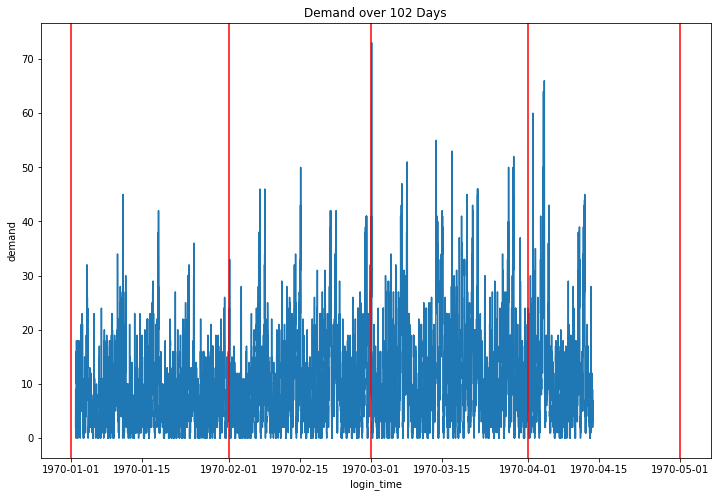

In [151]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df_int.index, y='demand', data=df_int)
plt.title('Demand over 102 Days')
months = [dt.datetime.strptime('1970-01-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-02-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-03-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-04-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-05-01', '%Y-%m-%d')]
for month in months:
    plt.axvline(month, c='red');

A quick glance seems to show a weekly pattern. Let's examine the data on a monthly basis to get a closer look.

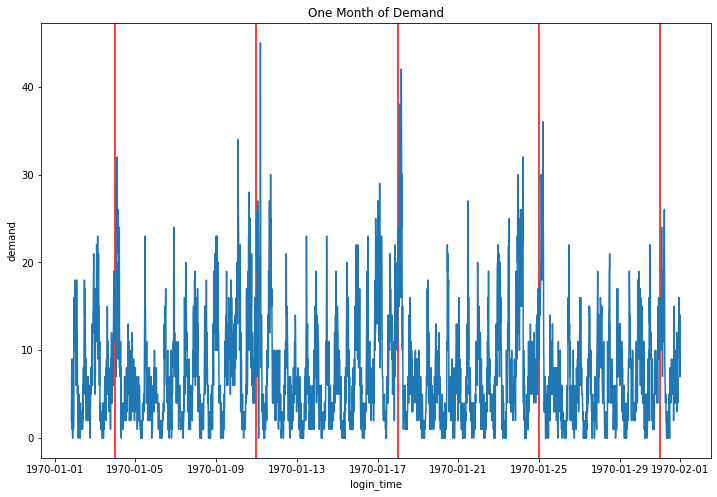

In [152]:
plt.figure(figsize=(12,8))
month = df_int.loc['1970-01']
plt.title('One Month of Demand')
plt.axvline(x=dt.datetime.strptime('1970-01-04', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-11', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-18', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-25', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-31', '%Y-%m-%d'), c='red')

sns.lineplot(x=month.index, y='demand', data=month);

There does appear to be a weekly seasonal component. Let's look closer at a single week.

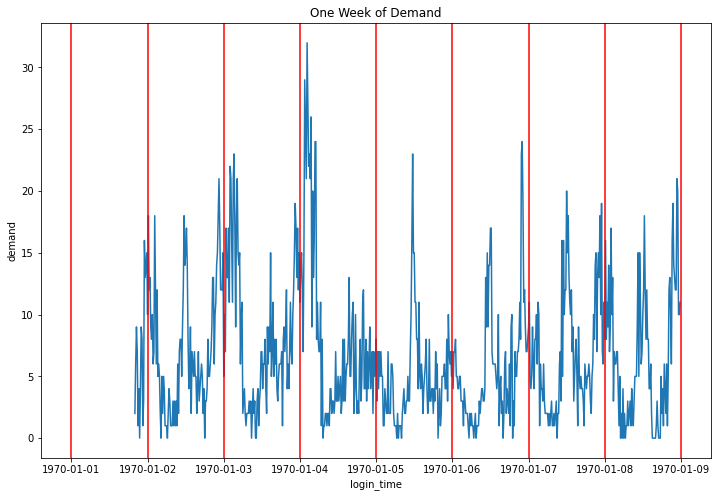

In [153]:
plt.figure(figsize=(12,8))
week = df_int.loc['1970-01-01':'1970-01-8']
plt.title('One Week of Demand')
day_markers = [dt.datetime.strptime(''.join(['1970-01-0', str(i)]), '%Y-%m-%d') for i in range(1,10)]
sns.lineplot(x=week.index, y='demand', data=week)
for day in day_markers:
    plt.axvline(x=day, c='red');

It looks like the seasonality might actually be on a 12-hour cycle!

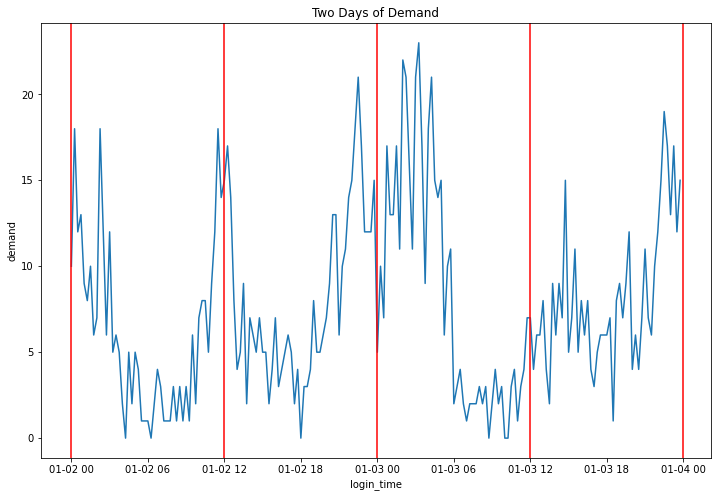

In [154]:
plt.figure(figsize=(12,8))
days = df_int.loc['1970-01-02':'1970-01-03']
plt.title('Two Days of Demand')
sns.lineplot(x=days.index, y='demand', data=days)
hourly_cycle = [dt.datetime.strptime('1970-01-02', '%Y-%m-%d')]
for cycle in range(5):
    hourly_cycle.append(hourly_cycle[cycle] + dt.timedelta(hours=12))
    plt.axvline(x=hourly_cycle[cycle], c='red');

Yes, that certainly appears to have an approximately 12-hour cycle.

In [156]:
df_int.loc['1970-01']

demand
login_time                 
1970-01-01 20:00:00       2
1970-01-01 20:15:00       6
1970-01-01 20:30:00       9
1970-01-01 20:45:00       7
1970-01-01 21:00:00       1
...                     ...
1970-01-31 22:45:00      16
1970-01-31 23:00:00      10
1970-01-31 23:15:00       9
1970-01-31 23:30:00       7
1970-01-31 23:45:00      14

[2896 rows x 1 columns]

## Look for Broader Patterns

We are going to aggregate the login counts by different frequencies to look for patterns too broad to see clearly at 15-minute intervals.

### Aggregate BiWeekly

In [177]:
df_biweekly = df.groupby([pd.Grouper(key='login_time', freq='2w')]).agg({'demand':'sum'})

In [191]:
X = range(len(df_biweekly.index))
y = df_biweekly['demand']
X = sm.add_constant(X)
biweekly_trendmodel = sm.OLS(y,X).fit()

In [194]:
line_y = biweekly_trendmodel.predict(X)

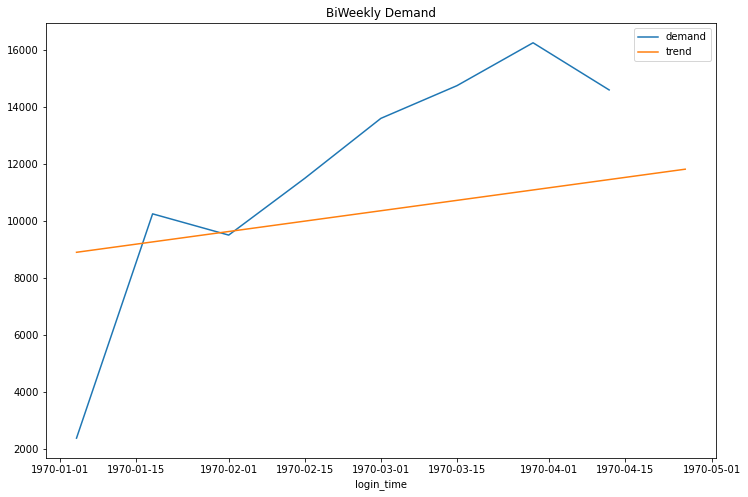

In [197]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_biweekly[0:-1])
sns.lineplot(x=df_biweekly.index, y=line_y, label='trend')
plt.title('BiWeekly Demand');

We can see a bit of an upward trend here, but there are so few datapoints that it isn't really meaningful. Might not show this to executives, as it could easily be misleading and is possibly a waste of time to talk about.

### Aggregate Weekly

In [203]:
df_weekly = df.groupby([pd.Grouper(key='login_time', freq='1w')]).agg({'demand':'sum'})

In [206]:
X = range(len(df_weekly.index))
y = df_weekly['demand']
X = sm.add_constant(X)
weekly_trendmodel = sm.OLS(y,X).fit()
line_y = weekly_trendmodel.predict(X)

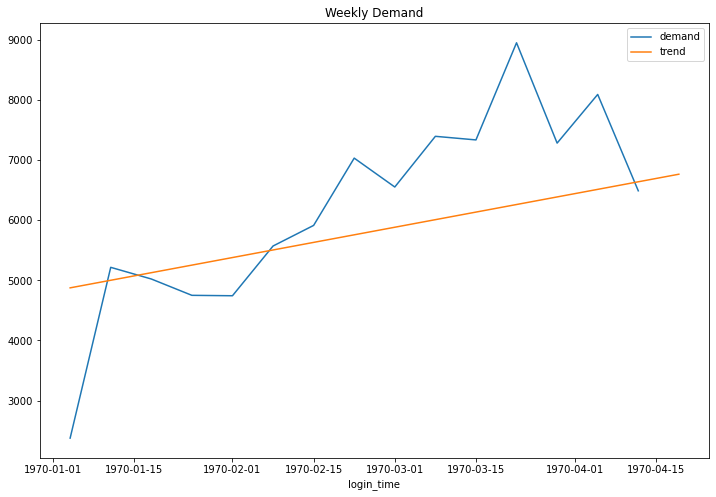

In [207]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_weekly[0:-1])
sns.lineplot(x=df_weekly.index, y=line_y, label='trend')
plt.title('Weekly Demand');

This trendline is much more meaningful. It still shows a slow increase in demand for Ultimate Technogies. At the weekly level, there is not much evidence of a pattern other than the upward trend of about 120 logins per week.

**CAUTION:** The trendline is **NOT** rigorous! It is a basic estimation.

### Aggregate Daily

In [210]:
df_daily = df.groupby([pd.Grouper(key='login_time', freq='1d')]).agg({'demand':'sum'})

In [211]:
X = range(len(df_daily.index))
y = df_daily['demand']
X = sm.add_constant(X)
daily_trendmodel = sm.OLS(y,X).fit()
line_y = daily_trendmodel.predict(X)

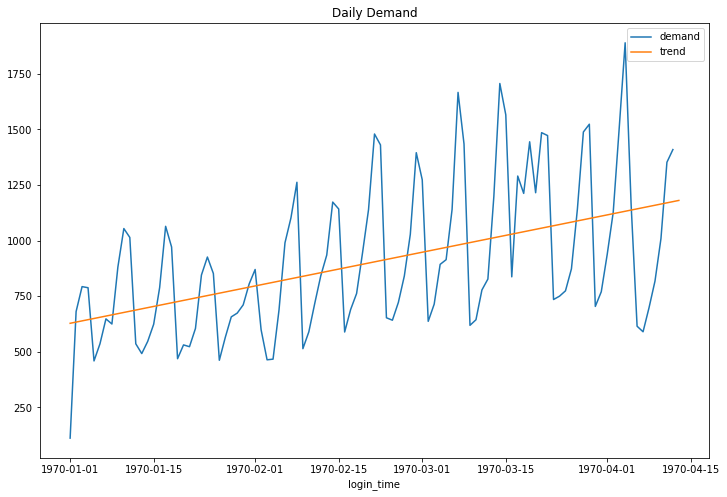

In [214]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_daily[0:-1])
sns.lineplot(x=df_daily.index, y=line_y, label='trend')
plt.title('Daily Demand');

There is a clear seasonality in the daily aggregation. Presumably, this pattern is people needing more rides either on the weekdays or weekends. The variance may also be increasing. Since this trendline looks pretty good and a large-enough sample size, I want to check the assumptions for the linear regression and see if this one can be rigorously trusted.

#### Residual Plots

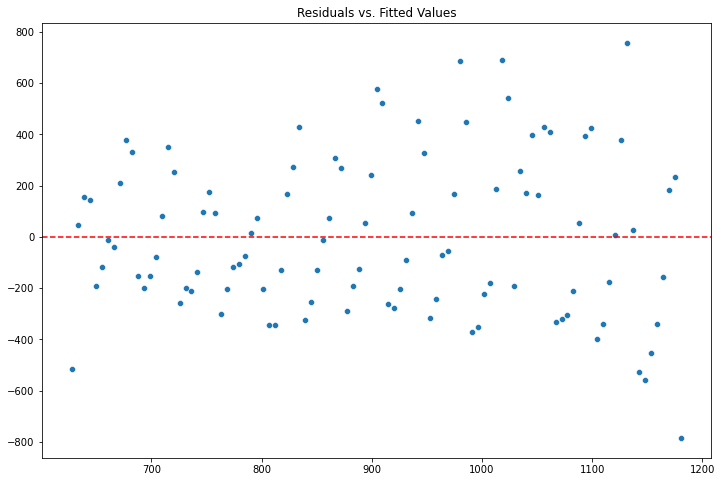

In [243]:
res = daily_trendmodel.resid
pred = line_y.copy()
plt.figure(figsize=(12,8))
plt.axhline(y=0, color='red', linestyle='dashed')
sns.scatterplot(x=pred, y=res)
plt.title('Residuals vs. Fitted Values');

These residuals actually look pretty good. They may grow a little bit as the predicted value gets higher, but not enough to make me worry about it. We should also check the residuals versus the predictor, or day.

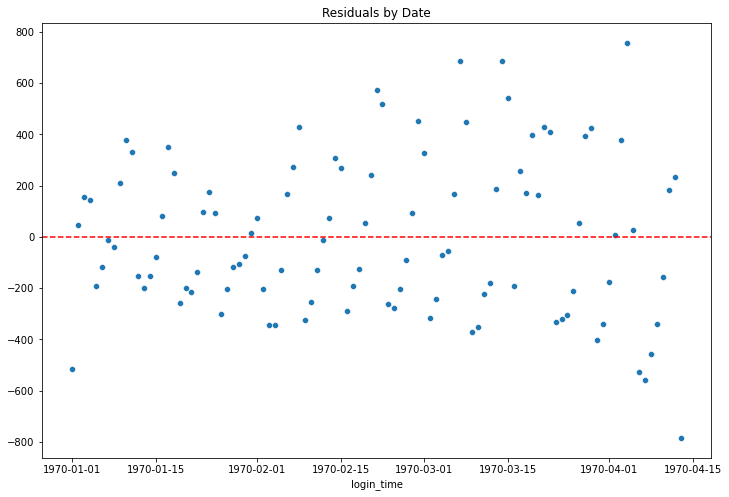

In [252]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=df_daily.index, y=res)
plt.axhline(0, color='red', linestyle='dashed')
plt.title('Residuals by Date');

The residuals look a *little* worse when plotted against the date. But not much. We just need to understand that the p-value we get in this regression may be a little lower than it should be. Let's view the regression summary now.

In [253]:
daily_trendmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     28.01
Date:                Thu, 25 Mar 2021   Prob (F-statistic):           7.06e-07
Time:                        14:23:07   Log-Likelihood:                -735.57
No. Observations:                 103   AIC:                             1475.
Df Residuals:                     101   BIC:                             1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        628.1764     60.393     10.401      0.000     508.372     747.981
x1             5.4140      1.023      5.292      0.000       3.385       7.443
==============================================================================
Omnibus:                        2.046   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                2.005
Skew:                           0.271   Prob(JB):                        0.367
Kurtosis:                       2.585   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The predicted trend is to gain about 5 more logins every day.**

### SARIMA Analysis of Daily Aggregated Data

There is clearly a seasonal component in the daily aggregation. However, there might also be heteroscedasticity which would make a GARCH model more appropriate. Here, though, we are going to use a Seasonal Auto-Regressive Integrated Moving Average model (SARIMA) to learn some things about the seasonal patterns.

We can start by looking at plots of the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF).

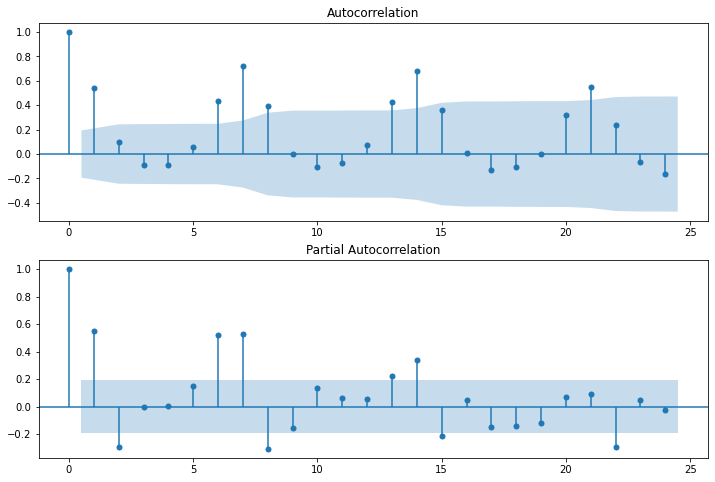

In [263]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'], lags=24, ax=ax2)
plt.show()

The ACF plot shows significant autocorrelation at multiples of 7 (and a day on either side of that lag). The PACF shows significant positive correlation at multiples of 7 as well, along with significant negative correlation at 3, 8, 15, and 23. Let's have a look at the ACF and PACF after first differencing.

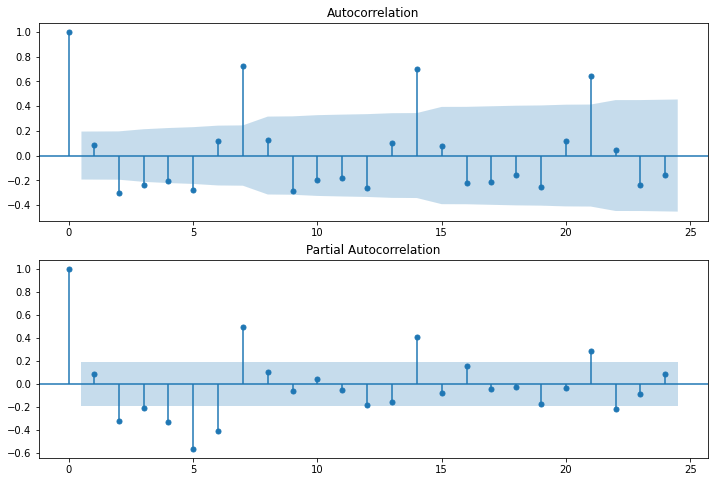

In [265]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'].diff().dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'].diff().dropna(), lags=24, ax=ax2)
plt.show()

Yeah, this ought to be easier to deal with. ACF shows weekly autocorrelation, and PACF shows weekly autocorrelation plus negative autocorrelation in lags 3-6. Let's also try the ACF and PACF of 7-differenced data.

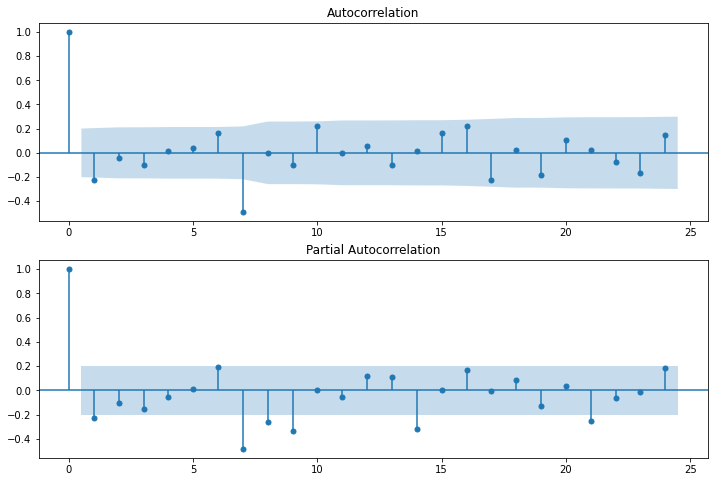

In [267]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'].diff().diff(7).dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'].diff().diff(7).dropna(), lags=24, ax=ax2)
plt.show()

On this differenced data, the ACF shows significant autocerrelation at lag 7, and the PACF shows autocorrelation at multiples of 7. They also both show a bit of significance at lag 1. We will now check the differenced series for stationarity, and if everything looks good we will fit an SARIMA(1,1,1)(1,1,1)7 model and draw some inference from that.

In [291]:
sm.tsa.stattools.adfuller(df_daily['demand'].diff().diff(7).dropna())

(-7.205263271588244,
 2.309080630259885e-10,
 8,
 86,
 {'1%': -3.5087828609430614,
  '5%': -2.895783561573195,
  '10%': -2.5850381719848565},
 1074.0380573581515)

The series is stationary (test statistic of -7.2 is more extreme than the 1% critical value of -3.5), so we can fit the model now.

In [328]:
model = sm.tsa.statespace.SARIMAX(df_daily['demand'], order=(1,1,1), seasonal_order=(1,1,1,7), trend='t')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            demand   No. Observations:                  103
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -609.028
Date:                           Fri, 26 Mar 2021   AIC                           1230.055
Time:                                   12:16:59   BIC                           1245.379
Sample:                               01-01-1970   HQIC                          1236.247
                                    - 04-13-1970                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0129      0.012     -1.054      0.292      -0.037       0.011
ar.L1          0.5907      0.143      4.132      0.000       0.311       0.871
ma.L1         -0.9989      2.028     -0.493      0.622      -4.974       2.976
ar.S.L7       -0.2409      0.189     -1.276      0.202      -0.611       0.129
ma.S.L7       -0.5939      0.144     -4.116      0.000      -0.877      -0.311
sigma2       1.95e+04   3.82e+04      0.511      0.610   -5.53e+04    9.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.37
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             0.12
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [331]:
np.sqrt(1.95e+04)

139.64240043768942

It turns out we didn't really need the seasonal auto-regressive coefficient (p=0.20) or the single-lag moving average coefficient (p=0.62). Also, the drift (trend) is not significant. There are also problems with the Jarque-Bera test, meaning the residuals are not normally distributed. This can also be seen in the high Kurtosis (normal distribution kurtosis = 3).

Most importantly, this more sophisticated model implies that there is no trend: The number of logins is **NOT** increasing over time!

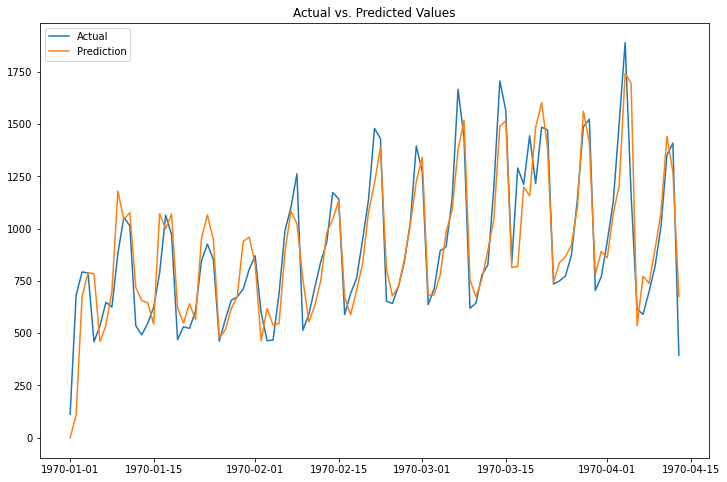

In [323]:
pred = results.predict()
plt.figure(figsize=(12,8))
plt.plot(df_daily, label='Actual')
plt.plot(pred, label='Prediction')
plt.title('Actual vs. Predicted Values')
plt.legend();

The model definitely seems to be capturing the behavior of the time series.

### Aggregate in 12-Hour periods

In [336]:
df_semidaily = df.groupby([pd.Grouper(key='login_time', freq='12h')]).agg({'demand':'sum'})

In [338]:
X = range(len(df_semidaily.index))
y = df_semidaily['demand']
X = sm.add_constant(X)
semidaily_trendmodel = sm.OLS(y,X).fit()
line_y = semidaily_trendmodel.predict(X)

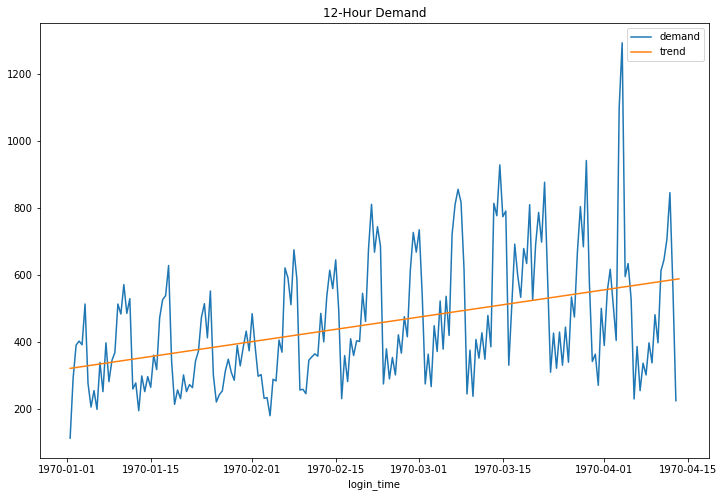

In [339]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_semidaily[0:-1])
sns.lineplot(x=df_semidaily.index, y=line_y, label='trend')
plt.title('12-Hour Demand');

The series is starting to show its variation more explicitly (longer times between measurements tends to denoise). While we can still see the 7-day seasonality, there is also a pattern in between the weekly spikes. The linear model predicts that the number of logins grows by about 1.3 every 12 hours; a slow but positive increase in the number of users. Let's look at creating a new SARIMA model to see what we can learn about the 12-hour patterns.

### 12-Hour SARIMA

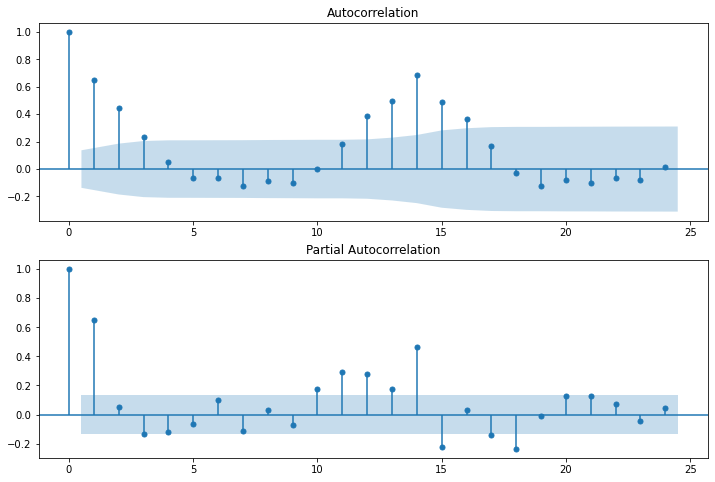

In [341]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_semidaily['demand'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_semidaily['demand'], lags=24, ax=ax2)
plt.show()

Both the ACF and PACF plots show the 14-period (7-day) pattern we expected from before. They also show signs of non-stationarity. Let's take the first difference and 14-period difference and plot them again.

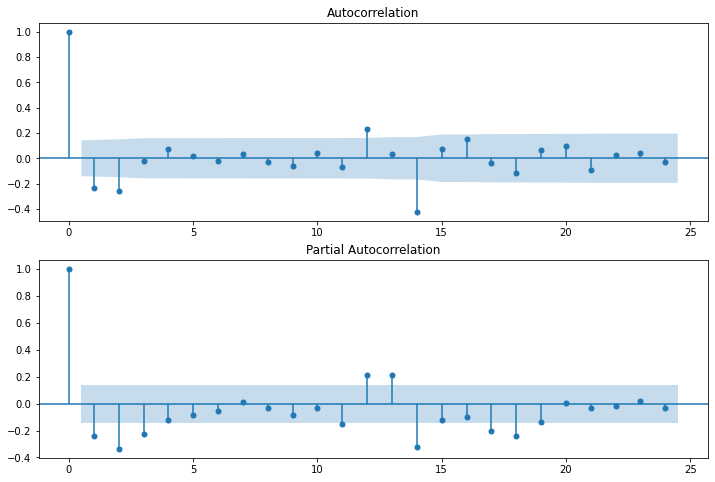

In [356]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_semidaily['demand'].diff().diff(14).dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_semidaily['demand'].diff().diff(14).dropna(), lags=24, ax=ax2)
plt.show()

There are still some significant lags. Let's build a SARIMA(3,1,0)(1,1,1)14 model and see what we can learn.

In [366]:
model = sm.tsa.statespace.SARIMAX(df_semidaily['demand'], order=(3,1,0), seasonal_order=(1,1,1,14), trend='t')
results = model.fit()


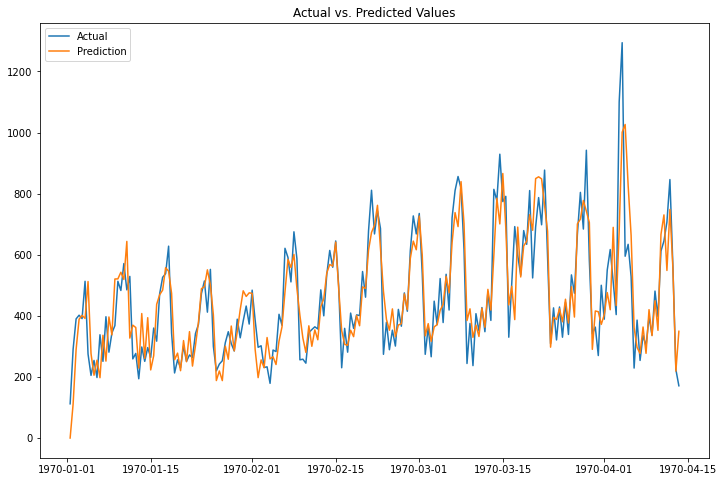

In [367]:
pred = results.predict()

plt.figure(figsize=(12,8))
plt.plot(df_semidaily, label='Actual')
plt.plot(pred, label='Prediction')
plt.title('Actual vs. Predicted Values')
plt.legend();

The model appears to be capturing the behavior of the time series quite well. Let's look for inference about the patterns.

In [368]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               demand   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 14)   Log Likelihood               -1141.202
Date:                              Fri, 26 Mar 2021   AIC                           2296.404
Time:                                      13:01:39   BIC                           2319.133
Sample:                                  01-01-1970   HQIC                          2305.611
                                       - 04-13-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0148      0.020     -0.753      0.452      -0.053       0.024
ar.L1         -0.4979      0.049    -10.150      0.000      -0.594      -0.402
ar.L2         -0.3608      0.049     -7.425      0.000      -0.456      -0.266
ar.L3         -0.2804      0.057     -4.916      0.000      -0.392      -0.169
ar.S.L14      -0.1759      0.125     -1.403      0.161      -0.422       0.070
ma.S.L14      -0.6741      0.103     -6.557      0.000      -0.876      -0.473
sigma2      9049.8647    778.176     11.630      0.000    7524.667    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               122.18
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again, there is no evidence of a trend over time (we should have expected that). There is still the 7-day cycle. Importantly, at a 12-hour level, differenced demand is autoregressive for 3 periods, and the relationship is negative. For example, if the demand has decreased over the last three 12-hour periods, we can expect it to increase in the next 12 hours.

Take this with a grain of salt; the residuals are seriously non-normal.

### Intraweek Patterns

In this section, we are going to use the 12-hour aggregation to, split the data into weeks, and then look for intraweek patterns.

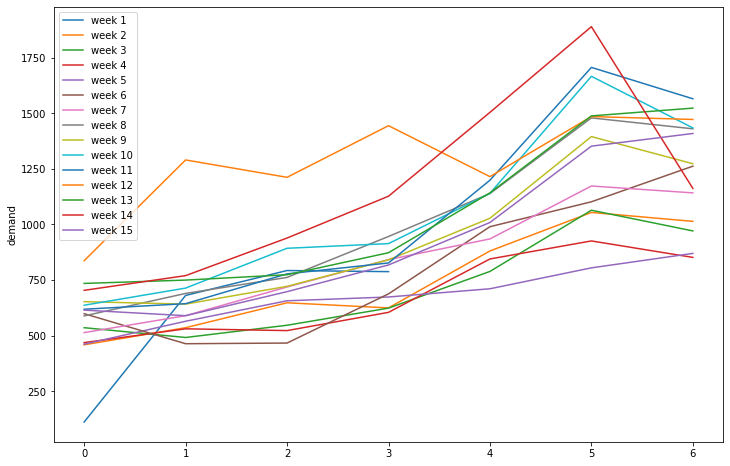

In [401]:
df_daily['week'] = df_daily.index.isocalendar().week
i = 1
plt.figure(figsize=(12,8))
for week in range(1, df_daily['week'].max()):
    temp = df_daily.loc[df_daily['week']==week, 'demand']
    sns.lineplot(x=range(len(temp)), y=temp, label=' '.join(['week', str(i)]))
    i += 1

We see a slow growth leading to a peak on the second-to-last day. Without knowing the actual date these observations were on, I cannot hypothesize the reason for this peak.

For this next plot, we are going to aggregate the date by hour, bin it into "morning", "afternoon", "evening", and "night", then group by the day of the week and looking at the average demand in each time_of_day over an average week.

In [416]:
df_hourly = df.groupby([pd.Grouper(key='login_time', freq='1h')]).agg({'demand':'sum'})
df_hourly['week'] = df_hourly.index.isocalendar().week
df_hourly['dayofweek'] = df_hourly.index.weekday
df_hourly['timeofday'] = 'night'
df_hourly.loc[df_hourly.index.hour > 6, 'timeofday'] = 'morning'
df_hourly.loc[df_hourly.index.hour > 12, 'timeofday'] = 'afternoon'
df_hourly.loc[df_hourly.index.hour > 18, 'timeofday'] = 'evening'

In [434]:
grouped_df = df_hourly.groupby(['dayofweek', 'timeofday']).mean()
grouped_df = grouped_df.reset_index()

In [435]:
import plotly.express as px

In [436]:
fig = px.bar(grouped_df, x="dayofweek", y="demand", color='timeofday', barmode='stack')
fig.show()

## Patterns in the Data

* There is a 7-day cycle
* The number of logins grows by between 0-5 per day
* There is a positive relationship between one day's change and the next day's; if demand increased/decreased yesterday, we expect it to increase/decrease today
* There is a negative relationship between a 12-hour period and the three preceding 12-hour periods; if demand increased/decreased for the last 36 hours, we expect it to decrease/increase over the next 12 hours
* 